In [1]:
import re
import sys
import string
import itertools
from collections import Counter
import os

import pandas as pd
import numpy as np
import kagglehub
from pathlib import Path

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import spacy


from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors # implements word vectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression

import matplotlib.cm as cm
import datetime
import warnings
warnings.filterwarnings('ignore')

/Users/oleksandrnovokhatskyi/Documents/Neovercity_Woolf/Deep_Learning/Deep_learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oleksandrnovokhatskyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oleksandrnovokhatskyi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/oleksandrnovokhatskyi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# 1. Environment diagnostics
if 'google.colab' in sys.modules:
    print("➡️ Running in Colab")
else:
    print("➡️ Running in local Python / VS Code")

# 2. Downloading the dataset via kagglehub
path = kagglehub.dataset_download("shantanudhakadd/email-spam-detection-dataset-classification")
path = Path(path)

print("Path to dataset files:", path)

print("Dataset root:", path)

➡️ Running in local Python / VS Code
Path to dataset files: /Users/oleksandrnovokhatskyi/.cache/kagglehub/datasets/shantanudhakadd/email-spam-detection-dataset-classification/versions/1
Dataset root: /Users/oleksandrnovokhatskyi/.cache/kagglehub/datasets/shantanudhakadd/email-spam-detection-dataset-classification/versions/1


In [3]:
df = pd.read_csv(path/"spam.csv", encoding='latin-1')
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.duplicated().sum()

np.int64(403)

In [7]:
df.drop_duplicates(inplace=True)

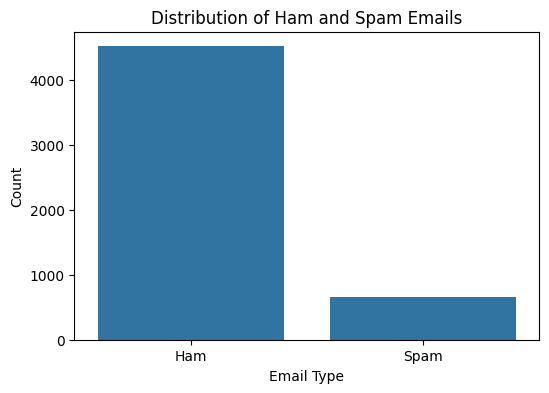

Кількісна іформація: 

Ham emails: 4516 

Spam emails: 653


In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham and Spam Emails')
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'])
plt.xlabel('Email Type')
plt.ylabel('Count')
plt.show()

print("Кількісна іформація:", '\n')
print("Ham emails:", df['label'].value_counts()[0], '\n')
print("Spam emails:", df['label'].value_counts()[1])

In [9]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


In [10]:
stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})

In [11]:
negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}
stop_words = stop_words.difference(negations)


In [12]:
stop_words = stop_words.difference(negations)

In [13]:
stemmer = PorterStemmer()

In [14]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

In [15]:
def normalize_text(raw_review):
    
    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >
    
    # Remove emails
    text = re.sub("\\S*@\\S*[\\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end
    
    # remove links
    text = re.sub("https?:\\/\\/.*?[\\s]+", " ", text) # match http, s - zero or once, //, 
                                                    # any char 0-unlimited, whitespaces in the end
        
     # Convert to lower case, split into individual words
    text = text.lower().split()
    
    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word 
            for word in text]
   
    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()    
    
    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)
    
    # Remove non-letters        
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '

    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])
    
    # Remove excesive whitespaces
    text = re.sub("[\\s]+", " ", text)    
    
    # Join the words back into one string separated by space, and return the result.
    return text


In [16]:
df['text_norm'] = df['text'].progress_apply(normalize_text)

100%|██████████| 5169/5169 [00:07<00:00, 708.83it/s]


In [17]:
X = df['text_norm']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                       test_size=0.2, 
                                                       stratify=y, 
                                                       random_state=42
                                                    )

In [18]:
bow_vect = CountVectorizer()
X_train_bow = bow_vect.fit_transform(X_train)
X_test_bow = bow_vect.transform(X_test)
print(X_train_bow.shape)

(4135, 6366)


In [19]:
tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [20]:
def get_preds(X_train, X_test, y_train, y_test, algorithm, ngrams=(1,2), threshold=0.6):
    
    if algorithm == 'cv':
        vect = CountVectorizer(ngram_range=ngrams)
    elif algorithm == 'tfidf':
        vect = TfidfVectorizer(ngram_range=ngrams)
    else:
        raise ValueError('Select correct algorithm: `cv` or `tfidf`')
            
    X_train_vec = vect.fit_transform(X_train)
    X_test_vec  = vect.transform(X_test)

    print("Vocabulary length:", len(vect.vocabulary_))
    print("Train matrix shape:", X_train_vec.shape)
    print("Test  matrix shape:", X_test_vec.shape)


    model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    model.fit(X_train_vec, y_train)

    proba_train = model.predict_proba(X_train_vec)[:, 1]
    proba_test  = model.predict_proba(X_test_vec)[:, 1]

    print("AUC (train):", roc_auc_score(y_train, proba_train))
    print("AUC (test) :", roc_auc_score(y_test, proba_test))

    y_pred = (proba_test >= threshold).astype(int)

    print("\nConfusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_test, y_pred))

    print("\nSpam(1) metrics at threshold =", threshold)
    print("Precision:", precision_score(y_test, y_pred, pos_label=1))
    print("Recall   :", recall_score(y_test, y_pred, pos_label=1))
    print("F1       :", f1_score(y_test, y_pred, pos_label=1))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    return model, vect, proba_test, y_pred


In [21]:
get_preds(X_train, X_test, y_train, y_test, algorithm='tfidf', ngrams=(1,2))

Vocabulary length: 30890
Train matrix shape: (4135, 30890)
Test  matrix shape: (1034, 30890)
AUC (train): 0.9990052948431217
AUC (test) : 0.9908236328438709

Confusion matrix (rows=true, cols=pred):
[[891  12]
 [ 18 113]]

Spam(1) metrics at threshold = 0.6
Precision: 0.904
Recall   : 0.8625954198473282
F1       : 0.8828125

Classification report:
              precision    recall  f1-score   support

           0     0.9802    0.9867    0.9834       903
           1     0.9040    0.8626    0.8828       131

    accuracy                         0.9710      1034
   macro avg     0.9421    0.9247    0.9331      1034
weighted avg     0.9705    0.9710    0.9707      1034



(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 TfidfVectorizer(ngram_range=(1, 2)),
 array([0.04979054, 0.08535085, 0.11197726, ..., 0.95471613, 0.14486478,
        0.13188261], shape=(1034,)),
 array([0, 0, 0, ..., 1, 0, 0], shape=(1034,)))

In [22]:
def build_corpus(data):
  corpus = []
  for sentence in data:
    word_list = sentence.split(" ")
    corpus.append(word_list)
  return corpus

In [23]:
corpus = build_corpus(df['text_norm'])
corpus[0]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'great',
 'world',
 'la',
 'buffet',
 'cine',
 'get',
 'amore',
 'wat']

In [28]:
# word2vec_file_path = 'pretrained_models/GoogleNews-vectors-negative300.bin'

# fasttext_file_path = 'pretrained_models/wiki-news-300d-1M.vec'

# from_scratch_file_path = 'saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
fname = "dolma_300_2024_1.2M.100_combined.txt"
embedding_path = (Path.cwd() / ".." / "pretrained_models" / fname).resolve()

out_dir = (Path.cwd() / ".." / "pretrained_models").resolve()
out_dir.mkdir(parents=True, exist_ok=True)  # на всяк випадок

glove_file_path = (out_dir / "glove.300_2024.vec").resolve()
print("CWD:", Path.cwd())
print("Embedding path:", embedding_path)
print("Exists:", embedding_path.exists())   # має бути True

CWD: /Users/oleksandrnovokhatskyi/Documents/Neovercity_Woolf/Deep_Learning/Deep_learning/NLP/HW_10
Embedding path: /Users/oleksandrnovokhatskyi/Documents/Neovercity_Woolf/Deep_Learning/Deep_learning/NLP/pretrained_models/dolma_300_2024_1.2M.100_combined.txt
Exists: True


In [29]:
word_embedding = WordEmbedding()

In [30]:
import time
t0 = time.perf_counter()
word_embedding.convert(source='glove', input_file_path=embedding_path, output_file_path=glove_file_path)

print("Seconds:", time.perf_counter() - t0)

Seconds: 288.2867614160059


In [33]:
my_vectors = KeyedVectors.load_word2vec_format(str(glove_file_path), binary=False)

print("Вектори успішно завантажено!")

Вектори успішно завантажено!


In [36]:
print("\nСлова, схожі на 'nice':")
try:
    print(my_vectors.most_similar('nice'))
except KeyError:
    pass


Слова, схожі на 'nice':
[('good', 0.9249852895736694), ('pretty', 0.9200864434242249), ('awesome', 0.9181800484657288), ('cool', 0.9155619144439697), ('perfect', 0.9143335223197937), ('really', 0.9117693305015564), ('very', 0.908996045589447), ('look', 0.9088160991668701), ('looks', 0.9087769985198975), ('looking', 0.9080296158790588)]


In [40]:
my_vectors.vector_size

300

In [43]:
def text_to_embedding(text, model=my_vectors):
    """Convert text to embedding by averaging word vectors"""
    words = text.split()
    vectors = [model[word] for word in words if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [ ]:
print("Creating embeddings...")
X_train_emb = np.array([text_to_embedding(text) for text in X_train])
X_test_emb = np.array([text_to_embedding(text) for text in X_test])

print(f"Train embeddings shape: {X_train_emb.shape}")
print(f"Test embeddings shape: {X_test_emb.shape}")

Creating embeddings...


In [47]:
model_emb = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
model_emb.fit(X_train_emb, y_train)
y_pred_emb = model_emb.predict(X_test_emb)

proba_test_emb = model_emb.predict_proba(X_test_emb)[:, 1]
print("AUC (test):", roc_auc_score(y_test, proba_test_emb))

print(confusion_matrix(y_test, y_pred_emb))
print("Precision:", precision_score(y_test, y_pred_emb, pos_label=1))
print("Recall   :", recall_score(y_test, y_pred_emb, pos_label=1))
print("F1       :", f1_score(y_test, y_pred_emb, pos_label=1))
print(classification_report(y_test, y_pred_emb, digits=4))

AUC (test): 0.9694825560261384
[[832  71]
 [ 12 119]]
Precision: 0.6263157894736842
Recall   : 0.9083969465648855
F1       : 0.7414330218068536
              precision    recall  f1-score   support

           0     0.9858    0.9214    0.9525       903
           1     0.6263    0.9084    0.7414       131

    accuracy                         0.9197      1034
   macro avg     0.8060    0.9149    0.8470      1034
weighted avg     0.9402    0.9197    0.9258      1034



In [48]:
get_preds(X_train, X_test, y_train, y_test, algorithm='tfidf', ngrams=(1,2))

Vocabulary length: 30890
Train matrix shape: (4135, 30890)
Test  matrix shape: (1034, 30890)
AUC (train): 0.9990052948431217
AUC (test) : 0.9908236328438709

Confusion matrix (rows=true, cols=pred):
[[891  12]
 [ 18 113]]

Spam(1) metrics at threshold = 0.6
Precision: 0.904
Recall   : 0.8625954198473282
F1       : 0.8828125

Classification report:
              precision    recall  f1-score   support

           0     0.9802    0.9867    0.9834       903
           1     0.9040    0.8626    0.8828       131

    accuracy                         0.9710      1034
   macro avg     0.9421    0.9247    0.9331      1034
weighted avg     0.9705    0.9710    0.9707      1034



(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 TfidfVectorizer(ngram_range=(1, 2)),
 array([0.04979054, 0.08535085, 0.11197726, ..., 0.95471613, 0.14486478,
        0.13188261], shape=(1034,)),
 array([0, 0, 0, ..., 1, 0, 0], shape=(1034,)))

In [49]:
get_preds(X_train, X_test, y_train, y_test, algorithm='cv', ngrams=(1,2))

Vocabulary length: 30890
Train matrix shape: (4135, 30890)
Test  matrix shape: (1034, 30890)
AUC (train): 0.9999962884135938
AUC (test) : 0.9912040441953454

Confusion matrix (rows=true, cols=pred):
[[901   2]
 [ 21 110]]

Spam(1) metrics at threshold = 0.6
Precision: 0.9821428571428571
Recall   : 0.8396946564885496
F1       : 0.9053497942386831

Classification report:
              precision    recall  f1-score   support

           0     0.9772    0.9978    0.9874       903
           1     0.9821    0.8397    0.9053       131

    accuracy                         0.9778      1034
   macro avg     0.9797    0.9187    0.9464      1034
weighted avg     0.9778    0.9778    0.9770      1034



(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 CountVectorizer(ngram_range=(1, 2)),
 array([6.56568960e-04, 1.24864516e-02, 1.25777479e-02, ...,
        9.98321602e-01, 1.04565622e-02, 1.50538215e-02], shape=(1034,)),
 array([0, 0, 0, ..., 1, 0, 0], shape=(1034,)))

Висновки:
Вхагалі високі результати, я з початку подемав, що модель перенавчилась. Але перевіриши AUC на тренувальному і на тестувлаьному наборі, наче, все ОК.

Найкраща модель, згідно результатів:
1. За показниками AUC - модель Bag-of-Words (BoW) - 0.99
2. Precision (Spam) BoW - 0,98
                    tfidf - 0.904
                    Glove - 0.62 Із усіх, кого модель назвала spam, лише 62.6% реально spam. Багато помилкових спрацювань. Більше ham листів йде в spam
3. Варто зазначити, що Recall найклащий у Glove - 0,90 це свідчить про те що більше 90 відсотків справжнбого спаму зловила

Загалом всі модлеі виконали завдання добре AUC більше 95 відсотків. На такому простому прикладі, мподі добре начаилися.